## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [95]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [96]:
df = pd.read_csv('ab_data.csv')
df.sample(5)

,user_id,timestamp,group,landing_page,converted
13061,825203,2017-01-11 02:22:43.643002,treatment,new_page,0
236959,710291,2017-01-05 04:57:50.980637,control,old_page,0
259864,840704,2017-01-06 02:12:04.281497,control,old_page,0
42778,805205,2017-01-09 15:50:51.156057,treatment,new_page,0
264681,861323,2017-01-18 02:27:45.668942,control,old_page,0


b. Use the cell below to find the number of rows in the dataset.

In [97]:
# Shape gives as a result the total amount of rows, columns
# get only rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [98]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [99]:
# converted = 1 and non converted = 0
# the sum of all values will give the amount of converted user
round(df['converted'].sum()/df.user_id.nunique()*100)

12.0

e. The number of times the `new_page` and `treatment` don't match.

In [100]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [101]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [102]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

In [103]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [104]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [105]:
df2[df2.duplicated(subset='user_id', keep='first')].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [106]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [107]:
df2 = df2.drop_duplicates(subset='user_id', keep='first')

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [108]:
df.converted.mean()

0.11965919355605512

b. Given that an individual was in the `control` group, what is the probability they converted?

In [109]:
df.query("group =='control'").converted.mean()

0.12039917935897611

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [110]:
df.query("group =='treatment'").converted.mean()

0.11891957956489856

d. What is the probability that an individual received the new page?

In [111]:
df.query("landing_page =='new_page'").shape[0]/df.user_id.nunique()

0.5067003000853454

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

Being 0.12 the probability of convesion for the old page and 0.119 for the new one, we can say that even though the calculated probabilities show that the old page leads to more conversions, the difference among the probabilities is not much. Therefore, there's not enough sufficient evidence to draqw a conclusion. 


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$**  =  **$p_{new}$**  -   **$p_{old}$**  ≤ 0

**$H_{1}$**  =  **$p_{new}$**  -   **$p_{old}$**  > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [112]:
p_new = (df2.converted == 1).mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [113]:
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [114]:
n_new = df2.query('group == "treatment"')['user_id'].nunique()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [115]:
n_old = df2.query('group == "control"')['user_id'].nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [116]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [117]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [118]:
new_page_converted.mean() - old_page_converted.mean()

0.00091327999410684146

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [119]:
new_converted_sim = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_sim = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_sim - old_converted_sim

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

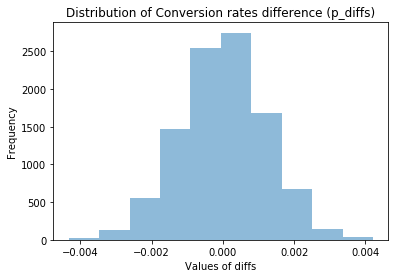

In [120]:
plt.hist(p_diffs, alpha = 0.5)
plt.title('Distribution of Conversion rates difference (p_diffs)')
plt.xlabel('Values of diffs')
plt.ylabel('Frequency');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [121]:
ab_diff = df.query("group =='treatment'").converted.mean() - df.query("group =='control'").converted.mean()

(p_diffs > ab_diff).mean()

0.89239999999999997

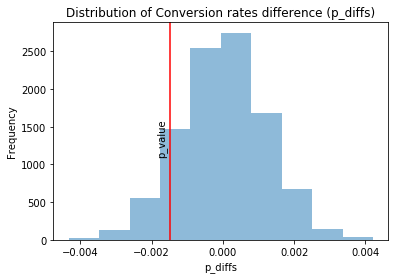

In [122]:
# plot p_diffs against the actual difference
plt.hist(p_diffs, alpha = 0.5)
plt.axvline(ab_diff, color='red')
plt.text(ab_diff-0.0004,1500,'p_value',rotation=90)
plt.title('Distribution of Conversion rates difference (p_diffs)')
plt.xlabel('p_diffs')
plt.ylabel('Frequency');

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value computed in part j is called the p-value, the probability of observing convertions if our null hypothesis is true.**

A large p_value suggests that we shouldn't move away from the null hypothesis, and if we have in consideration that the  treshold for a Type I error rate given ($\alpha$) was of 5%, and p_value is much greather than $\alpha$ then we can conclude that it's not possible to confirm that the new page turns out on more conversions. 

*We fail to reject the null hypothesis*


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [123]:
import statsmodels.api as sm
from scipy.stats import norm

convert_old = df2[(df2['group'] == 'control')].converted.sum()
convert_new = df2[(df2['group'] == 'treatment')].converted.sum()
n_old = n_old
n_new = n_new

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [124]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')

(z_score, p_value)

(1.3109241984234394, 0.90505831275902449)

In [125]:
# Calculate critical value for z test
norm.ppf(1-(0.05))

1.6448536269514722

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The p-value calculated agrees with the findings in j and k, a value way above the alpha value. 

On the pther side, the standard score (z-score) is smaller than the calculated critical value for a 95% confidence.

In conclusion, **we fail to reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Since the variable will be binary, it only takes two values, it should be used **Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [126]:
# Add intercept column 
df2['intercept'] = 1

# add dummy for ab_page column 
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [127]:
import statsmodels.api as sm

mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [128]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-14 21:14 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with ab_page is 0.1899. There's a big differece with the p-calue computated before, due to a change in the hypothesis.**
Before, we were comparing the values and trying to understand if a value is greater or equal than the other: 

**$H_{0}$**  =  **$p_{new}$**  -   **$p_{old}$**  ≤ 0

**$H_{1}$**  =  **$p_{new}$**  -   **$p_{old}$**  > 0


But with the logistic regression we're trying to understand if the values are equal or not: 

**$H_{0}$**  =  **$p_{new}$**  **$=$**    **$p_{old}$**  

**$H_{1}$**  =  **$p_{new}$**  **$\neq$** **$p_{old}$**  



f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding new factors is a good idea because it can help understand how the variable gets influeced by different factors. 
But, adding more variables can also bring dissadvantages if those new factors happen to be correlated with each other and not independent. The only correlation the new factors can have is with our response variable.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [129]:
# read the csv into a dataframe
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [130]:
# check how many couentries
df_countries.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [131]:
# left join on the user_id 
df2 = df2.merge(df_countries, how ='inner', on = ['user_id'])

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

In [132]:
# add dummy for ab_page column 
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])

#take only two, (CA & UK == 0) = US
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-04-14 21:14 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

## Conclusions

In every test performed in this analysis, we calculated p-values above the specified alpha of 0.05. Therefore, we fail to reject the null hypothesis. 

In conclusion, we can't indicate that the new page improves in any way the conversion rates in comparison with the old page. It could even be worse. 

## References
- [Think Stats](https://greenteapress.com/thinkstats/html/index.html)
- [Text and supporting code for Think Stats](https://github.com/AllenDowney/ThinkStats2)
- [Naked Statistics](https://www.amazon.de/Naked-Statistics-Stripping-Dread-Data/dp/039334777X)
- [Hypothesis tests and p-value: a gentle introduction](https://towardsdatascience.com/hypothesis-tests-and-p-value-a-gentle-introduction-4b52322bfc50)

In [133]:
# convert to html
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0